# Data Processing

## Remove Rows and Sample Randomly

We will now drop any rows that are irrelevant to us and save it to a CSV file.

In [ ]:
import pandas as pd

df = pd.read_csv('data/Books_rating.csv')

# preserve relevant columns and rename for ease of access
df = df[['review/summary', 'review/text', 'review/score']]
df.columns = ['summary', 'text', 'score']

# sample a portion of the data
n = 250000
df = df.sample(n=n, random_state=1)

# save to new csv file and view data
df.to_csv('data/Books_rating_relevant_columns.csv', index=False)
df.head()

## Stopwords, Lemmatization, and Vectorization

Process the text to remove stopwords, lemmatize, strip unneeded characters, then vectorize.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm

tqdm.pandas()

In [ ]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))


def stemmer(text):
    if text != text:
        return ''

    # clean the text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()

    # tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if not w in stopwords]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    text = ' '.join(tokens)

    return text

In [ ]:
df = pd.read_csv('data/Books_rating_relevant_columns.csv')

# apply stemmer to text
df['stemmed_text'] = df['text'].progress_apply(stemmer)
df['stemmed_summary'] = df['summary'].progress_apply(stemmer)
df['stemmed_summary_text'] = df['stemmed_summary'] + ' ' + df['stemmed_text']

# remove trailing spaces
df['stemmed_summary_text'] = df['stemmed_summary_text'].progress_apply(
    lambda x: x.strip())

# clean up NaN and remove empty rows
df.fillna('', inplace=True)
df = df[df['stemmed_summary_text'] != '']

# drop unused columns
df.drop(columns=['text', 'summary', 'stemmed_summary',
        'stemmed_text'], inplace=True)

# save to new csv file and view the data
df.to_csv('data/Books_rating_stemmed.csv', index=False)
df.head()

## Vectorizing

Vectorize the text using TF-IDF.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

tqdm.pandas()

In [ ]:
df = pd.read_csv('data/Books_rating_stemmed.csv')
print(f'Shape of dataframe: {df.shape}')

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_summary_text'], df['score'], test_size=0.2, random_state=1)

# init the vectorizer and fit on the training set
vectorizer = TfidfVectorizer(max_features=30_000, sublinear_tf=True)
vectorizer.fit(X_train)

# transform training and test sets
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# get shape of training and test sets
print(f'Shape of training set: {X_train.shape}')
print(f'Shape of testing set: {X_test.shape}')

# save vectorizer to disk
pickle.dump(vectorizer, open('models/vectorizer.pkl', 'wb'))
print('Vectorizer saved!')

## Model Testing

First testing different kinds of models, then further testing with hyperparameters.

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

Classification Report for MultinomialNB:
              precision    recall  f1-score   support

         1.0       0.78      0.14      0.23      3374
         2.0       0.53      0.01      0.02      2559
         3.0       0.36      0.01      0.02      4218
         4.0       0.34      0.04      0.08      9769
         5.0       0.62      0.99      0.76     30080

    accuracy                           0.61     50000
   macro avg       0.53      0.24      0.22     50000
weighted avg       0.55      0.61      0.49     50000



/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Classification Report for LogisticRegression:
              precision    recall  f1-score   support

         1.0       0.62      0.55      0.58      3374
         2.0       0.40      0.20      0.26      2559
         3.0       0.44      0.27      0.33      4218
         4.0       0.45      0.28      0.35      9769
         5.0       0.75      0.92      0.83     30080

    accuracy                           0.68     50000
   macro avg       0.53      0.44      0.47     50000
weighted avg       0.64      0.68      0.65     50000

Classification Report for LinearSVC:
              precision    recall  f1-score   support

         1.0       0.61      0.56      0.58      3374
         2.0       0.37      0.20      0.26      2559
         3.0       0.41      0.25      0.31      4218
         4.0       0.42      0.28      0.33      9769
         5.0       0.75      0.91      0.82     30080

    accuracy                           0.67     50000
   macro avg       0.51      0.44      0.46     

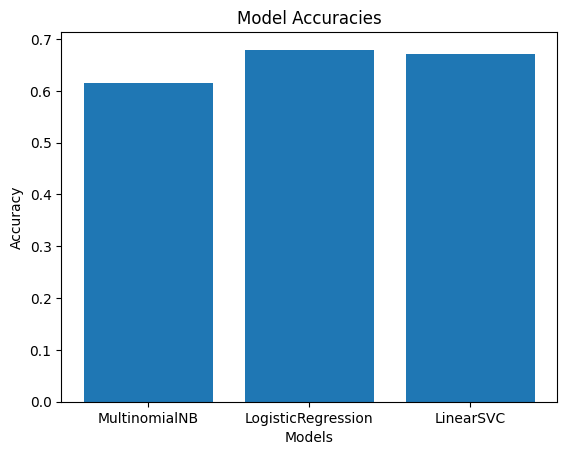

In [15]:
# Create a dictionary to store model instances
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC()
}

# Create lists to store model names and accuracies for plotting
model_names = []
accuracies = []

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print classification report for more detailed metrics
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Store model name and accuracy for plotting
    model_names.append(name)
    accuracies.append(accuracy)

# Plotting accuracies
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

At this point we decided to further test the LogisticRegression and LinearSVC since the Naive Bayes did not produce favorable results.

### Logistic Regression

### LinearSVC